# Data challenge

Your task is to build an algorithm for prohibitory traffic sign recognition. We have
created a training data set (20 images) that can be used for building and fine-tuning a model.
However, you are encouraged to collect more images, since it will allow you to improve your
model’s performance.

There are 6 traffic sign categories your model should be able to recognize:
* Category A - no right, left, or U-turn
* Category B - speed limit (regardless of the indicated value)
* Category C - road closed
* Category D - no entry
* Category E - no stopping, no parking
* Category F - other types of prohibitory traffic signs

## Couple of ideas
We could use the large source of great datasets on Kaggle about traffic signs, these are large enough for buiding a great model but we need to relabel the data for our desired classes.

e.g.
* [GTSRB - German Traffic Sign Recognition Benchmark][1]
* [Traffic Sign Dataset - Classification 🚦🚨🚑🚔🚦🚨🚑🚔🚦🚨🚑🚔][2]
* [Traffic Signs (GTSRB plus 162 custom classes)][3]

[1]: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
[2]: https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification
[3]: https://www.kaggle.com/datasets/daniildeltsov/traffic-signs-gtsrb-plus-162-custom-classes

Possible models to consider are CNNs,[Spatial Transformer Networks][4], [Vision Transformers][5] or whatever comes to your mind. We don't really have to use transformer models I just learned about them recently and I think they are fun. And the [attention mechanism][6] they use is useful if the model needs to focus on specific regions on an image.

[4]: https://arxiv.org/abs/1506.02025
[5]: https://arxiv.org/pdf/2010.11929.pdf
[6]: https://arxiv.org/abs/1706.03762

We should probably use transfer learning starting from a big model that already worked neatly on some big competition.

e.g.

* [VGG16 and VGG19][7]
* [ResNet and ResNetV2][8]
* [google/vit-base-patch16-224-in21k][9]
* [InceptionV3][10]
* [YOLOv8][11]

[7]: https://keras.io/api/applications/vgg/
[8]: https://keras.io/api/applications/resnet/
[9]: https://huggingface.co/google/vit-base-patch16-224-in21k
[10]: https://keras.io/api/applications/inceptionv3/
[11]: https://keras.io/api/keras_cv/models/backbones/yolo_v8/

I'm trying to implement the YOLOv8 model for this task, here are some great resources for it:

* https://yolov8.com/
* https://github.com/ultralytics/ultralytics
* https://docs.ultralytics.com/usage/python/
* https://universe.roboflow.com/rivne-state-humanitarian-university-faculty-of-mathematics-and-information-science/road-sign-detection-gmkcf

Apparently you can only use pytorch for implementing yolov8, but I'm not sure.

In [1]:
!pip install ruyaml
!pip install roboflow
!pip install ultralytics    # For using the YOLOv8 model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/95/da/72fda7a49ec81e369654eb6cfa733ec6e1ee87a7d1ed6a154c4cf6bf9c1d/roboflow-1.1.12-py3-none-any.whl.metadata
  Obtaining dependency information for certifi==2023.7.22 from https://files.pythonhosted.org/packages/4c/dd/2234eab22353ffc7d94e8d13177aaa050113286e93e7b40eae01fbf7c3d9/certifi-2023.7.22-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Obtaining dependency information for opencv-python-headless==4.8.0.74 from https://files.pythonhosted.org/packages/76/02/f128517f3ade4bb5f71e2afd8461dba70e3f466ce745fa1fd1fade9ad1b7/opencv_python_headless-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# import packages
import os
import wandb
import cv2
import ruyaml
from PIL import Image
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO, settings

# Set CUDA visible devices to GPU 0 and 1 (The 2xT4 GPUs that Kaggle provides)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# Hyperparameters of the model
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 50
BATCH_SIZE = 16
FREEZE_LAYERS = 18    # YOLOv8 has 22 layers
LEARNING_RATE = 0.01

# NUmber of training images
TRAIN_IMG_NUM = 20

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


In [3]:
wandb.login(key='d0b7cdd448f210185910e87afc905a43207241f8')

%env WANDB_LOG_MODEL=true

run = wandb.init(
    # Set the project where this run will be logged
    project='traffic_sign_recognition_data_challenge',
    # Track hyperparameters and run metadata
    config={
        'epochs': EPOCHS,
        'early_stopping_patience': EARLY_STOPPING_PATIENCE,
        'batch_size': BATCH_SIZE,
        'freeze_layers': FREEZE_LAYERS,
        'learning_rate': LEARNING_RATE,
    },
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_LOG_MODEL=true


wandb: Currently logged in as: emmermarci (import_this). Use `wandb login --relogin` to force relogin


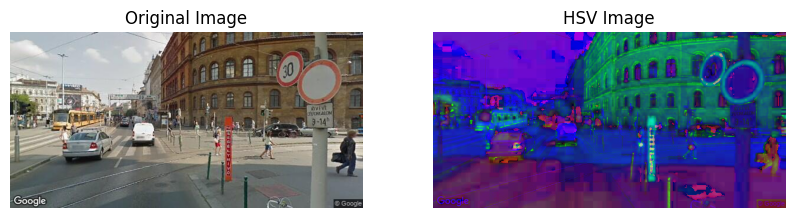

In [4]:
# Display a training image
file_path = '/kaggle/input/traffic/training_images/1.jpg'
# Load the image
image = cv2.imread(file_path)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display the HSV image
plt.subplot(1, 2, 2)
plt.imshow(hsv_image)
plt.title('HSV Image')
plt.axis('off')

plt.show()

# Creating a cutom dataset on Roboflow

https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/

In [5]:
rf = Roboflow(api_key="02cRttc1qMlRhPr5zpdP")
project = rf.workspace("trafficsignrecognitiondatachallenge").project("traffic-sign-recognition-r6zlr")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.227, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to traffic-sign-recognition-2 in yolov8:: 100%|██████████| 92/92 [00:00<00:00, 5983.41it/s]


In [7]:
# Load the YAML file
data_path = f'{dataset.location}/data.yaml'
with open(data_path, 'r') as file:
    data = ruyaml.load(file, Loader=ruyaml.RoundTripLoader)

# Update the 'val' path
data['train'] = '../train/images'
data['val'] = '../valid/images'

# Save the modified YAML file
with open(data_path, 'w') as file:
    ruyaml.dump(data, file, Dumper=ruyaml.RoundTripDumper)

In [8]:
# View all settings
print(settings)

# Return a specific setting
value = settings['runs_dir']

{'settings_version': '0.0.4', 'datasets_dir': '/kaggle/working/datasets', 'weights_dir': 'weights', 'runs_dir': 'runs', 'uuid': '1bfc3e992d24318da58ddee183be5bf9388a31f26bab1738e986ec4d297417ff', 'sync': True, 'api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}


## Example usage of the YOLOv8 model.

### You need to have a [Weights & Biases][1] account to run this code. We are using the YOLOv8 model by selecting 'yolov8n.pt'. This model is great at [detection tasks][2]. I recommend browsing though the [docs][3] for the implementation of this model.

[1]: https://wandb.ai/site
[2]: https://docs.ultralytics.com/tasks/detect/
[3]: https://docs.ultralytics.com/

In [9]:
# Load the pretrained model
model = YOLO('yolov8n.pt')

# The wandb magic command displays the details of the run
%wandb

# Train the model with 2 GPUs
results = model.train(project='traffic_sign_recognition_data_challenge',    # wandb project name
                      data=data_path,                      # Path to data file
                      epochs=EPOCHS,                       # Number of epochs to train for
                      patience=EARLY_STOPPING_PATIENCE,    # Epochs to wait for no observable improvement for early stopping
                      batch=BATCH_SIZE,                    # Number of images per batch
                      freeze=FREEZE_LAYERS,                # Freeze the first n layers
                      imgsz=640,                           # Size of input images (640x640 pixels)
                      device=[0, 1],                       # Run on the 2 T4 GPUs provided by Kaggle
                      seed=42,)                            # Random seed for reproducibility

100%|██████████| 6.23M/6.23M [00:00<00:00, 69.8MB/s]


Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/traffic-sign-recognition-2/data.yaml, epochs=20, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=traffic_sign_recognition_data_challenge, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=18, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]
2023-12-16 22:28:27,159	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-16 22:28:27,993	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorBoard: Start with 'tensorboard --logdir traffic_sign_recognition_data_challenge/train', view at http://localhost:6006/


wandb: Currently logged in as: emmermarci (import_this). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231216_222850-ta0q14ne
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/import_this/traffic_sign_recognition_data_challenge
wandb: 🚀 View run at https://wandb.ai/import_this/traffic_sign_recognition_data_challenge/runs/ta0q14ne


Overriding model.yaml nc=80 with nc=6
Transferred 319/355 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.c

train: Scanning /kaggle/working/traffic-sign-recognition-2/train/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 1202.97it/s]


train: New cache created: /kaggle/working/traffic-sign-recognition-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: New cache created: /kaggle/working/traffic-sign-recognition-2/valid/labels.cache


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
val: Scanning /kaggle/working/traffic-sign-recognition-2/valid/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2702.86it/s]


Plotting labels to traffic_sign_recognition_data_challenge/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to traffic_sign_recognition_data_challenge/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.541G      1.355      4.811      1.383         12        640: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


                   all          5         10    0.00267        0.3      0.027     0.0027

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.552G      1.409      4.605      1.312         19        640: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


                   all          5         10    0.00358        0.3     0.0263    0.00263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.564G      1.514      4.721      1.304         18        640: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


                   all          5         10    0.00386        0.3     0.0236    0.00236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.577G      1.363      4.548      1.244         26        640: 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


                   all          5         10    0.00414        0.3     0.0197    0.00197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.564G      1.353      4.596      1.335         16        640: 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


                   all          5         10    0.00471        0.3     0.0234    0.00334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.566G      1.407      4.514      1.344         17        640: 100%|██████████| 2/2 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


                   all          5         10    0.00561        0.3     0.0208    0.00313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.573G      1.575      5.194      1.322         11        640: 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


                   all          5         10    0.00606        0.3     0.0187    0.00278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.564G      1.581      4.435      1.359         26        640: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


                   all          5         10    0.00542        0.3     0.0152    0.00289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.564G       1.34      4.374      1.257         17        640: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


                   all          5         10    0.00567        0.3     0.0166    0.00339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.566G      1.423      4.447      1.249         24        640: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


                   all          5         10   0.000595        0.2     0.0142    0.00426
Stopping training early as no improvement observed in last 5 epochs. Best results observed at epoch 5, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

10 epochs completed in 0.005 hours.
Optimizer stripped from traffic_sign_recognition_data_challenge/train/weights/last.pt, 6.2MB
Optimizer stripped from traffic_sign_recognition_data_challenge/train/weights/best.pt, 6.2MB

Validating traffic_sign_recognition_data_challenge/train/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


                   all          5         10     0.0048        0.3     0.0214    0.00294
              no-entry          5          1    0.00227          1     0.0398    0.00796
no-right-left-or-u-turn          5          1          0          0          0          0
no-stopping-no-parking          5          2     0.0217        0.5     0.0674    0.00674
                 other          5          4          0          0          0          0
           speed-limit          5          2          0          0          0          0
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to traffic_sign_recognition_data_challenge/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▂▄▅▆▆▇▇██
wandb:                  lr/pg1 ▁▂▄▅▆▆▇▇██
wandb:                  lr/pg2 ▁▂▄▅▆▆▇▇██
wandb:        metrics/mAP50(B) ██▆▄▆▄▃▁▂▅
wandb:     metrics/mAP50-95(B) ▅▄▃▁█▇▅▆█▆
wandb:    metrics/precision(B) ▁▃▃▄▅▇█▇▇▅
wandb:       metrics/recall(B) ▁▁▁▁▁▁▁▁▁▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃▆▂▁▃██▁▃
wandb:          train/cls_loss ▅▃▄▂▃▂█▂▁▂
wandb:          train/dfl_loss █▄▄▁▆▆▅▇▂▁
wandb:            val/box_loss ▅█▅▇▄▂▁▃▂▁
wandb:            val/cls_loss ▇█▅▅▅▅▄▄▂▁
wandb:            val/dfl_loss ▅▅▂▆▃█▁▂▃▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 8e-05
wandb:                  lr/pg1 8e-05
wandb:                  lr/pg2 8e-05
wandb:        metrics/mAP50(B) 0.02144
wandb:     metrics/mAP50-95(B) 0.00294
wandb:    metrics/preci

In [10]:
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/traffic-sign-recognition-2/valid/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


                   all          5         10     0.0048        0.3     0.0203    0.00272
              no-entry          5          1    0.00225          1     0.0343    0.00686
no-right-left-or-u-turn          5          1          0          0          0          0
no-stopping-no-parking          5          2     0.0217        0.5     0.0674    0.00674
                 other          5          4          0          0          0          0
           speed-limit          5          2          0          0          0          0
Speed: 0.4ms preprocess, 20.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to traffic_sign_recognition_data_challenge/train2


In [11]:
results = model('/kaggle/input/traffic/training_images/1.jpg')    # predict on an image

# Process results list
for result in results:
    boxes = result.boxes            # Boxes object for bbox outputs
    masks = result.masks            # Masks object for segmentation masks outputs
    keypoints = result.keypoints    # Keypoints object for pose outputs
    probs = result.probs            # Probs object for classification outputs
    
    im_array = result.plot()        # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()                       # show image
    im.save('results.jpg')          # save image
    
path = model.export()   # export the model to PYTORCH format


image 1/1 /kaggle/input/traffic/training_images/1.jpg: 320x640 (no detections), 68.8ms
Speed: 1.4ms preprocess, 68.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)

PyTorch: starting from 'traffic_sign_recognition_data_challenge/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (6.0 MB)

TorchScript: starting export with torch 2.0.0...


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp5ewfu0jl.PNG'


TorchScript: export success ✅ 1.5s, saved as 'traffic_sign_recognition_data_challenge/train/weights/best.torchscript' (11.9 MB)

Export complete (1.5s)
Results saved to /kaggle/working/traffic_sign_recognition_data_challenge/train/weights
Predict:         yolo predict task=detect model=traffic_sign_recognition_data_challenge/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=traffic_sign_recognition_data_challenge/train/weights/best.torchscript imgsz=640 data=/kaggle/working/traffic-sign-recognition-2/data.yaml  
Visualize:       https://netron.app
